# Proyecto 1
<h3>Natalia Ortega (sección 4), David Leon (sección 3) & Juan Camilo Mercado (sección 4)</h3>

## 0. Carga de librerías y datos

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import sklearn as sklearn
import numpy as np
import nltk
import random
import statistics
import string
import unicodedata

from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from nltk.probability import *
from nltk.tokenize import word_tokenize

from scipy import stats as st

from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC

from gensim.models import Word2Vec

from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold 
from sklearn import tree


In [43]:
nltk.download('punkt');
nltk.download('stopwords');
nltk.download('wordnet');

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\CAMILO\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\CAMILO\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\CAMILO\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [44]:
df = pd.read_csv('./data/tipo2_entrenamiento_estudiantes.csv', sep=',', encoding = 'utf-8')

## 1. Entendimiento y preparación de datos

### Entendimiento

In [45]:
print(f">> Se puede observar que el df de entrenamiento contiene {df.shape[0]} reseñas")

>> Se puede observar que el df de entrenamiento contiene 7875 reseñas


In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7875 entries, 0 to 7874
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  7875 non-null   object
 1   Class   7875 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 123.2+ KB


In [47]:
print(">> El df se ve de la siguiente forma:")
df.head()

>> El df se ve de la siguiente forma:


,Review,Class
0,Muy buena atención y aclaración de dudas por p...,5
1,Buen hotel si están obligados a estar cerca de...,3
2,"Es un lugar muy lindo para fotografías, visite...",5
3,Abusados con la factura de alimentos siempre s...,3
4,Tuvimos un par de personas en el grupo que rea...,3


In [48]:
textos = df.copy()
textos['Conteo'] = [len(x) for x in textos['Review']]
textos['Palabras únicas'] = [len(set(x)) for x in textos['Review']]
textos['Max. de palabra'] = [[max([len(x) for x in i.split(' ')])][0] for i in textos['Review']]
textos['Min. de palabra'] = [[min([len(x) for x in i.split(' ')])][0] for i in textos['Review']]
textos['Moda'] = [statistics.mode(i.split(' ')) for i in textos['Review']]

textos

,Review,Class,Conteo,Palabras únicas,Max. de palabra,Min. de palabra,Moda
0,Muy buena atención y aclaración de dudas por p...,5,252,28,20,0,
1,Buen hotel si están obligados a estar cerca de...,3,297,34,13,1,de
2,"Es un lugar muy lindo para fotografías, visite...",5,104,26,12,1,Es
3,Abusados con la factura de alimentos siempre s...,3,422,28,14,1,y
4,Tuvimos un par de personas en el grupo que rea...,3,419,35,14,1,el
...,...,...,...,...,...,...,...
7870,"Me parece buen sistema, agiliza el transporte,...",4,113,24,11,2,el
7871,"Fue una escapada de un día desde el complejo, ...",4,261,31,12,2,de
7872,La Plaza de la Revolución es un lugar emblemát...,3,777,43,14,1,de
7873,Es la segunda ocasión que me quedo en los cuar...,1,651,38,12,0,que


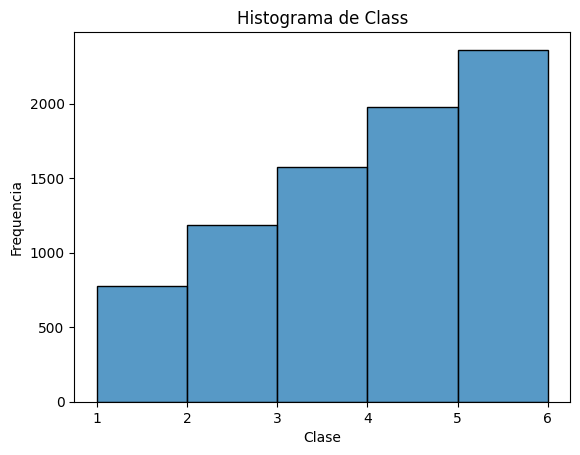

In [49]:
sns.histplot(data=textos, x='Class', bins=range(1, 7), kde=False)
plt.xlabel('Clase')
plt.ylabel('Frequencia')
plt.title('Histograma de Class')
plt.xticks(range(1, 7))
plt.show()

In [50]:
textos.describe()

,Class,Conteo,Palabras únicas,Max. de palabra,Min. de palabra
count,7875.000000,7875.000000,7875.000000,7875.000000,7875.000000
mean,3.502603,408.050413,33.117714,13.145778,0.858413
std,1.320435,474.145795,7.896652,2.930502,0.515585
min,1.000000,9.000000,9.000000,4.000000,0.000000
25%,3.000000,196.000000,28.000000,11.000000,1.000000
50%,4.000000,269.000000,31.000000,13.000000,1.000000
75%,5.000000,488.000000,37.000000,14.000000,1.000000
max,5.000000,10403.000000,80.000000,76.000000,5.000000


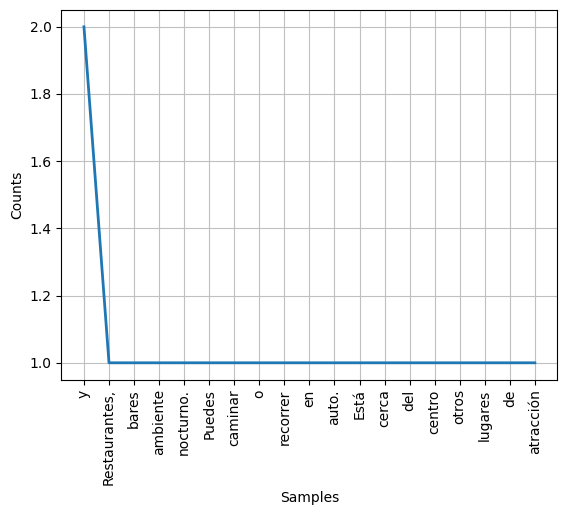

<Axes: xlabel='Samples', ylabel='Counts'>

In [51]:
fdist = FreqDist(df['Review'][random.randint(0, df.shape[0])].split(' '))
fdist.plot(30, cumulative = False)

### Segmentación de palabras (tokenización)

In [52]:

token_df = df.copy()
token_df['Words'] = df['Review'].apply(word_tokenize)
token_df.head()

,Review,Class,Words
0,Muy buena atención y aclaración de dudas por p...,5,"[Muy, buena, atención, y, aclaración, de, duda..."
1,Buen hotel si están obligados a estar cerca de...,3,"[Buen, hotel, si, están, obligados, a, estar, ..."
2,"Es un lugar muy lindo para fotografías, visite...",5,"[Es, un, lugar, muy, lindo, para, fotografías,..."
3,Abusados con la factura de alimentos siempre s...,3,"[Abusados, con, la, factura, de, alimentos, si..."
4,Tuvimos un par de personas en el grupo que rea...,3,"[Tuvimos, un, par, de, personas, en, el, grupo..."


### Limpieza de datos (StopWords) y análisis lexicográfico

In [53]:
class TextProcessor:
    def __init__(self):
        self.stop_words = set(stopwords.words('spanish'))
        self.lemmatizer = WordNetLemmatizer()
        self.stemmer = SnowballStemmer('spanish')
        self.punctuation = string.punctuation

    def to_lowercase(self, texto):
        return [word.lower() for word in texto]

    def remove_punctuation(self, texto):
        return [word for word in texto if word not in self.punctuation]

    def remove_stopwords(self, texto):
        return [word for word in texto if word not in self.stop_words]

    def lemmatize(self, texto):
        return [self.lemmatizer.lemmatize(word) for word in texto]

    def stem(self, texto):
        return [self.stemmer.stem(word) for word in texto]

    def remove_non_ascii(self, texto):
        return [unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore') for word in texto]

    def preprocess(self, texto):
        texto = self.to_lowercase(texto)
        texto = self.remove_punctuation(texto)
        texto = self.remove_stopwords(texto)
        texto = self.lemmatize(texto)
        texto = self.stem(texto)
        texto = self.remove_non_ascii(texto)
        return texto

In [54]:
processor = TextProcessor()
token_df['Stemmed words'] = [processor.preprocess(text) for text in token_df['Words']]
token_df.head()

,Review,Class,Words,Stemmed words
0,Muy buena atención y aclaración de dudas por p...,5,"[Muy, buena, atención, y, aclaración, de, duda...","[buen, atencion, aclar, dud, part, senorit, ve..."
1,Buen hotel si están obligados a estar cerca de...,3,"[Buen, hotel, si, están, obligados, a, estar, ...","[buen, hotel, si, oblig, cerc, centr, convenci..."
2,"Es un lugar muy lindo para fotografías, visite...",5,"[Es, un, lugar, muy, lindo, para, fotografías,...","[lug, lind, fotograf, visit, selin, music, viv..."
3,Abusados con la factura de alimentos siempre s...,3,"[Abusados, con, la, factura, de, alimentos, si...","[abus, factur, aliment, siempr, echan, culp, v..."
4,Tuvimos un par de personas en el grupo que rea...,3,"[Tuvimos, un, par, de, personas, en, el, grupo...","[par, person, grup, realment, quer, com, cabri..."


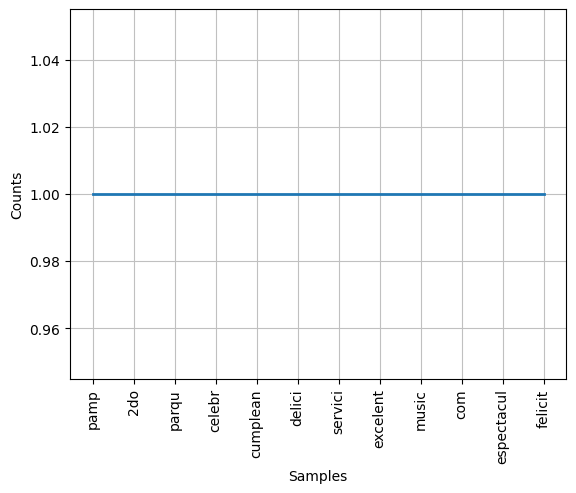

<Axes: xlabel='Samples', ylabel='Counts'>

In [55]:
fdist = FreqDist(token_df['Stemmed words'][random.randint(0, df.shape[0])])
fdist.plot(30, cumulative = False)

### Vectorización de texto

In [56]:
def cleaning(text):
    return [processor.preprocess(text_token) for text_token in word_tokenize(text)]
    

In [57]:
token_df

,Review,Class,Words,Stemmed words
0,Muy buena atención y aclaración de dudas por p...,5,"[Muy, buena, atención, y, aclaración, de, duda...","[buen, atencion, aclar, dud, part, senorit, ve..."
1,Buen hotel si están obligados a estar cerca de...,3,"[Buen, hotel, si, están, obligados, a, estar, ...","[buen, hotel, si, oblig, cerc, centr, convenci..."
2,"Es un lugar muy lindo para fotografías, visite...",5,"[Es, un, lugar, muy, lindo, para, fotografías,...","[lug, lind, fotograf, visit, selin, music, viv..."
3,Abusados con la factura de alimentos siempre s...,3,"[Abusados, con, la, factura, de, alimentos, si...","[abus, factur, aliment, siempr, echan, culp, v..."
4,Tuvimos un par de personas en el grupo que rea...,3,"[Tuvimos, un, par, de, personas, en, el, grupo...","[par, person, grup, realment, quer, com, cabri..."
...,...,...,...,...
7870,"Me parece buen sistema, agiliza el transporte,...",4,"[Me, parece, buen, sistema, ,, agiliza, el, tr...","[parec, buen, sistem, agiliz, transport, conec..."
7871,"Fue una escapada de un día desde el complejo, ...",4,"[Fue, una, escapada, de, un, día, desde, el, c...","[escap, dia, complej, grup, turist, gui, infor..."
7872,La Plaza de la Revolución es un lugar emblemát...,3,"[La, Plaza, de, la, Revolución, es, un, lugar,...","[plaz, revolu, lug, emblemat, identif, haban, ..."
7873,Es la segunda ocasión que me quedo en los cuar...,1,"[Es, la, segunda, ocasión, que, me, quedo, en,...","[segund, ocasion, qued, cuart, are, jardin, co..."


### Modelado

In [58]:
token_df['Text'] = [' '.join(text) for text in token_df['Stemmed words']]


X = token_df['Text']
Y = token_df['Class']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=777)
X_modeling, X_validation, Y_modeling, Y_validation = train_test_split(X_train, Y_train, test_size=0.2, random_state=777)

In [59]:
def word2vec(model):
    sentences = [text.split() for text in X_train]
    word2vec_vectorizer = Word2Vec(sentences, vector_size=3, window=2, min_count=1)
    X_list_train = []
    for text in sentences:
        vector = np.zeros(3) 
        for word in text:
            if word in word2vec_vectorizer.wv:
                vector += word2vec_vectorizer.wv[word]
        X_list_train.append(vector)
    X_temp_train = np.array(X_list_train)
    X_temp_modeling, X_temp_validation, Y_temp_modeling, Y_temp_validation = train_test_split(X_temp_train, Y_train, test_size=0.2, random_state=777)
    model.fit(X_temp_modeling, Y_temp_modeling)
    Y_temp_pred_validation = model.predict(X_temp_validation)
    score = f1_score(Y_temp_validation, Y_temp_pred_validation, average='micro')
    return word2vec_vectorizer, score, model


In [60]:
def best_vectorizer(model):
    best_vectorizer = None
    best_score = 0
    for vectorizer in ['CountVectorizer', 'TfidfVectorizer']:
        if vectorizer == 'CountVectorizer':
            vectorizer = CountVectorizer()
        else:
            vectorizer = TfidfVectorizer()
        X_modeling_transformed = vectorizer.fit_transform(X_modeling)
        model.fit(X_modeling_transformed, Y_modeling)
        X_validation_transformed = vectorizer.transform(X_validation)
        Y_pred_validation = model.predict(X_validation_transformed)
        score = f1_score(Y_validation, Y_pred_validation, average='micro')
        if score > best_score:
            best_score = score
            best_vectorizer = vectorizer
    try:
        word2vec_vectorizer, word2vec_score, word2vec_model = word2vec(model)
        if word2vec_score > best_score:
            best_score = word2vec_score
            best_vectorizer = word2vec_vectorizer
            model = word2vec_model
    except:
        print("(!) No se pudo realizar word2vec por el motivo mostrado")
    print(f">> El mejor vectorizador es {best_vectorizer} con un score f1 de {best_score}")
    return best_vectorizer, model

#### Modelado con 'Clasificador Red Neuronal' (Camilo Mercado)

In [61]:
# particiones = KFold(n_splits=75, shuffle=True, random_state=777)
# param_grid = {'activation': ['identity', 'logistic', 'tanh', 'relu'],'solver':['lbfgs', 'sgd', 'adam'], 'learning_rate': ['constant', 'invscaling', 'adaptive']}
# algorithm = MLPClassifier( alpha=1e-5, random_state=777)
# model = GridSearchCV(algorithm, param_grid, cv=particiones, scoring='f1_micro')
# vectorizer, model = best_vectorizer(model)
# model.best_params_

In [76]:
model = MLPClassifier( alpha=1e-5, random_state=777, activation='logistic', solver='lbfgs', learning_rate='adaptive', max_iter=1000)
vectorizer, model = best_vectorizer(model)

In [73]:
X_train_transformed = vectorizer.fit_transform(X_train)
model.fit(X_train_transformed, Y_train)
X_test_transformed = vectorizer.transform(X_test)
Y_pred_test = model.predict(X_test_transformed)
score = f1_score(Y_test, Y_pred_test, average='micro')
print(f">> El puntaje f1 de test es {score}")

>> El puntaje f1 de test es 0.4641269841269841


In [ ]:
arbol_final = model.best_estimator_

#### Validación cuantitativa con 'árboles de clasificación' (Camilo Mercado)

In [ ]:
model = MLPClassifier( alpha=1e-5, random_state=777)

vectorizer, model = best_vectorizer(model)

>> El mejor vectorizador es CountVectorizer() con un score f1 de 0.43333333333333335


#### Modelado con 'SVC' ()

In [ ]:
model = SVC()

vectorizer, model = best_vectorizer(model)

>> El mejor vectorizador es TfidfVectorizer() con un score f1 de 0.4658730158730159


#### Validación cuantitativa con 'SVC' ()

#### Modelado con 'Naive-Bayes multinomial' ()

In [ ]:
model = MultinomialNB()

vectorizer, model = best_vectorizer(model)

>> El mejor vectorizador es CountVectorizer() con un score f1 de 0.44761904761904764


#### Validación cuantitativa con 'Naive-Bayes multinomial' ()